# Installation des dépendances

Pour pouvoir exécuter ce Notebook, l'environnement de développement doit être bien configuré.

<div class="alert alert-info">
    Pour ce Notebook, on pourra choisir le kernel <code>conda_tensorflow2_p310</code> sur SageMaker.
</div>

In [55]:
!pip install spacy transformers datasets sentencepiece seaborn pandas -q

De même, nous allons utiliser un jeu de données supplémentaire de HuggingFace pour enrichir notre base.

In [2]:
!git lfs install
!git clone https://huggingface.co/datasets/Paul/hatecheck-french

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'hatecheck-french'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), 80.00 KiB | 2.76 MiB/s, done.


Enfin, spaCy nous permettra de faire des opérations de traitement du texte adapté à la langue française.

In [3]:
!python -m spacy download fr_core_news_sm

2023-03-18 14:21:28.629460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 14:21:29.577346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-18 14:21:29.577457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-18 14:21:29.577479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Analyse exploratoire des données

Pour cette analyse exploiratoire, le dataset `mlma.csv` doit être présent dans l'environnement de développement, situé dans le même dossier que ce Notebook.

In [4]:
!mkdir -p data/
!wget -q https://blent-keskia.s3.eu-west-3.amazonaws.com/poc/cyberharcelement/french_tweets.csv.zip -O data/french_tweets.csv.zip
!wget -q https://blent-keskia.s3.eu-west-3.amazonaws.com/poc/cyberharcelement/mlma.csv -O data/mlma.csv
!unzip -o data/french_tweets.csv.zip -d data

Archive:  data/french_tweets.csv.zip
  inflating: data/french_tweets.csv  


In [56]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set()

data = pd.read_csv("data/mlma.csv")
tweets = pd.read_csv("data/french_tweets.csv")


De même, nous chargeons le jeu de données HateCheck téléchargé depuis HuggingFace.

In [57]:
tweets.head()

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


In [61]:
hatecheck = pd.read_csv("hatecheck-french/test.csv")

Regardons à quoi ressemblent les deux jeux de données.

In [58]:
data.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
0,1,rt @user personnage ainsi q tte la clique gauc...,abusive,direct,shock,origin,other
1,2,@user @user @user bah oui t'as raison l'autre ...,offensive,indirect,shock,other,individual
2,3,moi j'ai personne à qui m'adresser pour réclam...,hateful,direct,anger_confusion_sadness_fear_disgust,other,women
3,4,@user @user c...est vrai que les anchois sont ...,normal,indirect,indifference,other,other
4,5,eh les renois faut se réveiller la @url,normal,direct,sadness,origin,african_descent


In [60]:
hatecheck.head()

,mhc_case_id,functionality,test_case,label_gold,target_ident,ref_case_id,ref_templ_id,templ_id,case_templ,gender_male,gender_female,label_annotated,label_annotated_maj,disagreement_in_case,disagreement_in_template
0,french-1,derog_neg_emote_h,Je déteste les femmes.,hateful,women,NaN,NaN,1,Je déteste les [IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
1,french-2,derog_neg_emote_h,Je déteste les trans.,hateful,trans people,NaN,NaN,1,Je déteste les [IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
2,french-3,derog_neg_emote_h,Je déteste les homos.,hateful,gay people,NaN,NaN,1,Je déteste les [IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
3,french-4,derog_neg_emote_h,Je déteste les blacks.,hateful,black people,NaN,NaN,1,Je déteste les [IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False
4,french-5,derog_neg_emote_h,Je déteste les handicapés.,hateful,disabled people,NaN,NaN,1,Je déteste les [IDENT_P].,NaN,NaN,"['hateful', 'hateful', 'hateful']",hateful,False,False


La colonne `sentiment` du premier jeu de données indique si le Tweet est normal, offensif ou encore haineux.

In [62]:
len(data["sentiment"].unique())

69

Il y a potentiellement des modalités qui se chevauchent : nous pourrions être amenés à en fusionner plusieurs entre-elles.

In [11]:
hatecheck["label_gold"].unique()

array(['hateful', 'non-hateful'], dtype=object)

Le deuxième jeu de données est quant à lui binaire sur le sentiment.

In [14]:
data["group"].unique()

array(['other', 'individual', 'women', 'african_descent', 'immigrants',
       'arabs', 'indian/hindu', 'special_needs', 'left_wing_people',
       'asians', 'jews', 'muslims', 'christian', 'hispanics', 'refugees',
       'gay'], dtype=object)

Ce qui est intéressant avec les deux jeux de données, c'est que nous avons également à disposition le groupe d'individus visé par le commentaire.

In [15]:
hatecheck["target_ident"].unique()

array(['women', 'trans people', 'gay people', 'black people',
       'disabled people', 'Muslims', 'refugees', nan], dtype=object)

Essayons de visualiser quelques lignes.

### ➡️ À toi de jouer

Afficher quelques lignes donc le sentiment est `fearful_normal` pour la dataset MLMA.

In [63]:
data.loc[(data["sentiment"] == "fearful_normal")][["group", "target", "sentiment"]]


,group,target,sentiment
66,immigrants,origin,fearful_normal
178,other,other,fearful_normal
386,individual,other,fearful_normal
1003,other,other,fearful_normal
1273,other,other,fearful_normal
1577,muslims,religion,fearful_normal
1711,muslims,religion,fearful_normal
1975,left_wing_people,other,fearful_normal
2361,muslims,religion,fearful_normal
2492,other,other,fearful_normal


### ➡️ À toi de jouer

Afficher quelques lignes donc le sentiment est `normal` pour la dataset MLMA.

In [64]:
data.loc[(data["sentiment"] == "normal")]

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group
3,4,@user @user c...est vrai que les anchois sont ...,normal,indirect,indifference,other,other
4,5,eh les renois faut se réveiller la @url,normal,direct,sadness,origin,african_descent
6,7,@user sjw et féministe twitter un sale combo,normal,indirect,sadness_indifference,other,women
7,8,@user @user tu sais aussi pourquoi est au dess...,normal,indirect,indifference,other,other
11,12,@user dekoi tu parle jte dis ta ps honte de di...,normal,direct,indifference,origin,indian/hindu
...,...,...,...,...,...,...,...
3988,3989,@user ne t'attarde pas là dessus!,normal,indirect,indifference,other,other
3992,3993,@user quand il n'est plus possible d'établir d...,normal,indirect,indifference,other,other
3998,3999,@user quand vous prendrez vos sources ailleurs...,normal,indirect,confusion_indifference,other,other
4001,4002,@user @user je suis actuellement en amerique j...,normal,indirect,indifference,other,other


Ce qui est important pour ce POC, c'est de **différencier ce qui relève de la plaisanterie dans un groupe d'amis d'un harcèlement haineux**. Pour cela, la **notion de contexte sera donc très importante**.

Dans ces deux exemples précédents, nous allons considérer les sentiments `normal` et `fearful_normal` comme `non-hateful`, de sorte à harmoniser les labels entre les deux jeux de données.

### ➡️ À toi de jouer

Sur la dataset MLMA, transformer tous les sentiments `normal` et `fearful_normal` en `non-hateful`.

In [65]:
data["sentiment"].loc[(data["sentiment"] == "normal")] = "non-hateful"
data["sentiment"].loc[(data["sentiment"] == "fearful_normal")] = "non-hateful"



<ipython-input-65-b4b04bf27433>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sentiment"].loc[(data["sentiment"] == "normal")] = "non-hateful"
<ipython-input-65-b4b04bf27433>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["sentiment"].loc[(data["sentiment"] == "fearful_normal")] = "non-hateful"


Maintenant, nous allons **concaténer tous les datasets en un seul**.

In [66]:
from sklearn.utils import shuffle

# df représente notre DataFrame final du traitement de données
df1 = pd.DataFrame()
df1["Text"] = data["tweet"]
df1["Group"] = data["group"]
df1["Type"] = data["sentiment"]

df2 = pd.DataFrame()
df2["Text"] = hatecheck["test_case"]
df2["Group"] = hatecheck["target_ident"]
df2["Type"] = hatecheck["label_gold"]

# On ajoute des Tweets random non offensants
df3 = pd.DataFrame()
n_tweets = 10000
df3["Text"] = tweets.sample(n=n_tweets)["text"]
df3["Group"] = "other"
df3["Type"] = "non-hateful"

df = pd.concat([df1, df2, df3], axis=0)
df = shuffle(df)

In [69]:
df.head()
df["Type"].unique()

array(['non-hateful', 'hateful_normal', 'offensive', 'offensive_hateful',
       'abusive', 'hateful', 'fearful', 'abusive_normal',
       'abusive_offensive', 'abusive_hateful', 'fearful_abusive',
       'disrespectful', 'abusive_disrespectful', 'hateful_disrespectful',
       'fearful_disrespectful_hateful_normal',
       'fearful_abusive_disrespectful_normal',
       'offensive_disrespectful_normal', 'abusive_offensive_normal',
       'disrespectful_hateful', 'abusive_offensive_hateful_disrespectful',
       'fearful_hateful', 'offensive_normal',
       'abusive_offensive_disrespectful', 'disrespectful_normal',
       'fearful_offensive_hateful_normal',
       'offensive_hateful_disrespectful_normal',
       'fearful_offensive_disrespectful', 'offensive_disrespectful',
       'offensive_hateful_disrespectful',
       'fearful_abusive_hateful_disrespectful_normal',
       'abusive_offensive_disrespectful_normal',
       'fearful_abusive_offensive_disrespectful',
       'fearful_abusi

Dans notre cas, nous allons rester sur de la classification binaire.

### ➡️ À toi de jouer

Dans le dataset `df`, remplacer tous les types **différents de `non-hateful`** par `hateful`.

In [74]:
df["Type"].loc[(df["Type"] != "non-hateful")] = "hateful"
df.head()
df["Type"].unique()


array(['non-hateful', 'hateful'], dtype=object)

Vérifions bien que nous n'ayons que deux classes.

In [75]:
df["Type"].unique()

array(['non-hateful', 'hateful'], dtype=object)

Vérifions également les groupes d'individus.

In [76]:
df["Group"].unique()

array(['other', 'arabs', 'jews', nan, 'special_needs', 'refugees',
       'black people', 'indian/hindu', 'disabled people', 'gay people',
       'individual', 'Muslims', 'women', 'trans people', 'asians',
       'african_descent', 'christian', 'left_wing_people', 'immigrants',
       'muslims', 'hispanics', 'gay'], dtype=object)

Là-aussi pour simplifier l'entraînement du modèle, nous allons fusionner certains groupes.

In [77]:
df["Group"].loc[(df["Group"] == "gay people")] = "gay"
df["Group"].loc[(df["Group"] == "trans people")] = "gay"
df["Group"].loc[(df["Group"] == "black people")] = "african_descent"
df["Group"].loc[(df["Group"] == "Muslims")] = "muslims"
df["Group"].loc[(df["Group"] == "disabled people")] = "special_needs"
df["Group"].loc[(df["Group"] == "refugees")] = "immigrants"
df["Group"].loc[(df["Group"] == "individual")] = "other"

Regardons à nouveau les groupes uniques.

In [78]:
df["Group"].unique()

array(['other', 'arabs', 'jews', nan, 'special_needs', 'immigrants',
       'african_descent', 'indian/hindu', 'gay', 'muslims', 'women',
       'asians', 'christian', 'left_wing_people', 'hispanics'],
      dtype=object)

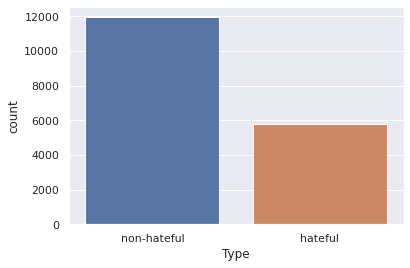

In [79]:
sns.countplot(x=df["Type"])
plt.show()

Visuellement, nous avons une sur-représentation de commentaires haineux : il faudrait potentiellement enrichir le jeu de données avec des commentaires non haineux.

### ➡️ À toi de jouer

Afficher le nombre de lignes de données pour chaque communauté/groupe d'individus.

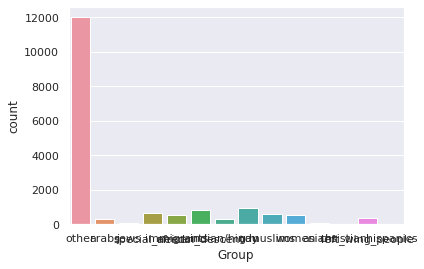

In [92]:
len(df["Group"])
sns.countplot(x=df["Group"])
plt.show()

Concernant les groupes d'individus, la plupart sont plutôt équilibrés, même si les 4 derniers groupes semblent être moins représentés.

### ➡️ À toi de jouer

Afficher le nombre de lignes de données `hateful` et `non-hateful` pour chaque communauté/groupe d'individus.

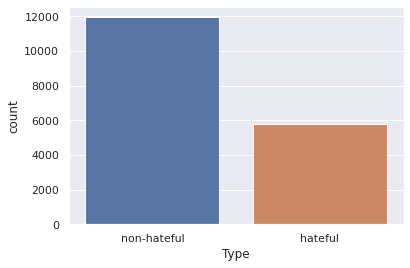

In [94]:
len(df["Type"])
sns.countplot(x=df["Type"])
plt.show()